Esercitazione Valsecchi-Molteni

mat. Valsecchi: 730030

mat. Molteni: 730113

Domanda: come si sviluppa il contagio in base a densità demografica e pil

In [1]:
from dateutil.parser import parse
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
import seaborn as sns
from sklearn import metrics
from sklearn import preprocessing
from scipy import interpolate
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.nonparametric.smoothers_lowess import lowess
%matplotlib inline
print('setup complete')

setup complete


In [2]:
%run funzioni.ipynb
print(test_util())

Import complete


In [3]:
naz=pd.read_csv("italy_total.csv")#dataset contenente dati a livello nazionale
######################################
reg=pd.read_csv("italy_region.csv")#dataset contenente dati a livello regionale 22
reg=reg.drop(['lat','long'], axis=1)#drop colonna stato contenente valori inutili
######################################
prov=pd.read_csv("italy_province.csv")
#prov=prov.dropna()#drop righe contenenti valori nan fare scriptino per gestire napoli
prov=prov.drop(['lat','long'], axis=1)#drop colonna stato contenente valori non utili
prov=prov.fillna('X') #definisco come sigle di provincia X le denominazioni in fase di definizione/aggiornamento E la sigla di napoli
prov.loc[prov['province_code']==63, 'province_abb']='NA'#sostituisco la X per la provincia di napoli con NA in quanto è stato considerato valore nan in fase di caricamento
######################################
glob= pd.read_csv("globale2.csv", sep=';')
glob.columns=[str.replace("/","_") for str in glob.columns]#sostituisco nelle colonne / con _
######################################
chita= pd.read_csv("ChIta.csv", sep=';') #importo dataset con dati demografici ed economici Italia e Cina
chita=chita.rename(columns={"PIL(MLD)":"PIL"})
chita=chita.drop(['Contagi'], axis=1)#in quanto non viene utilizzata
#ds_chita.sort_values(by=['Contagi'], ascending = False, inplace = True) #ordino in maniera decrescente
#il PIL è in dollari americani

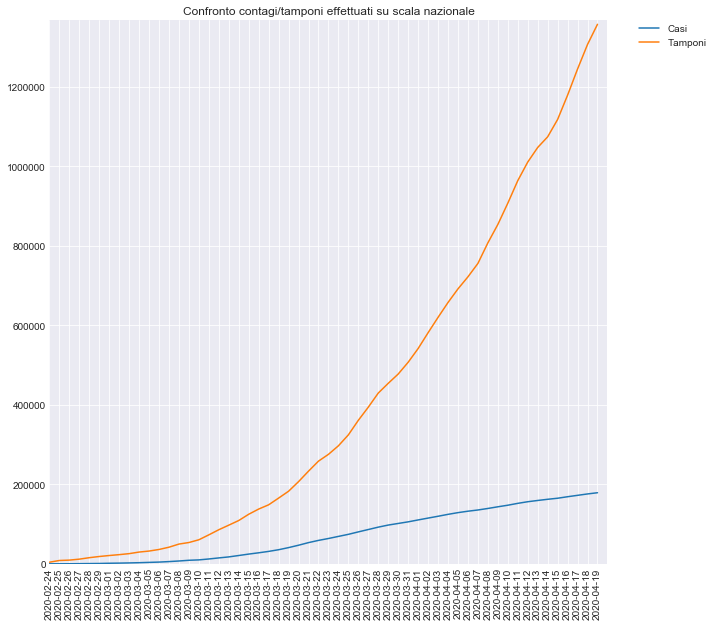

In [4]:
plt.style.use('seaborn-darkgrid')
plt.subplots(figsize=(10,10))
plt.plot(naz['date'],naz['cumulative_cases'], label='Casi')
plt.plot(naz['date'],naz['total_tests'], label='Tamponi')

limy=naz.loc[naz.shape[0]-1]['total_tests']+10000

plt.xlim(0,len(naz)) #imposto grandezze asse x
plt.ylim(0,limy) #imposto grandezze asse y
plt.xticks(rotation='vertical') #ruoto i label asse x
plt.margins(2)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Confronto contagi/tamponi effettuati su scala nazionale')
plt.show()

In [5]:
last_date=reg.loc[587]['date']#ottengo data dell'ultima registrazione

regg=reg.copy()

indexNames = regg[ regg['date'] != last_date ].index
regg.drop(indexNames , inplace=True)#droppo tutte le righe che non hanno la data pari all'ultimo record

regioni=[x for x in regg.region_name]#genero liste contenenti i dati dell'ultima data
casi=[x for x in regg.cumulative_cases]

combinato=combina(regioni, casi)#ottengo lista contenente la coppia regione-contagiati
combinato=sorted(combinato, key = itemgetter(1))#ordino la lista

regg=reg.copy()

primi_tre=[combinato[-1][0], combinato[-2][0], combinato[-3][0]]#memorizzo le prime 3 regioni colpite

cronologia_primi_tre_contagi=crono_contagi(regg, primi_tre)#array ocntenente la cronologia di crescita dei contagiati nelle 3 regioni

cronologia_primi_tre_tamponi=crono_tamponi(regg, primi_tre)#array contenente la cronologia di crescita dei tamponi nelle prime 3 regioni colpite


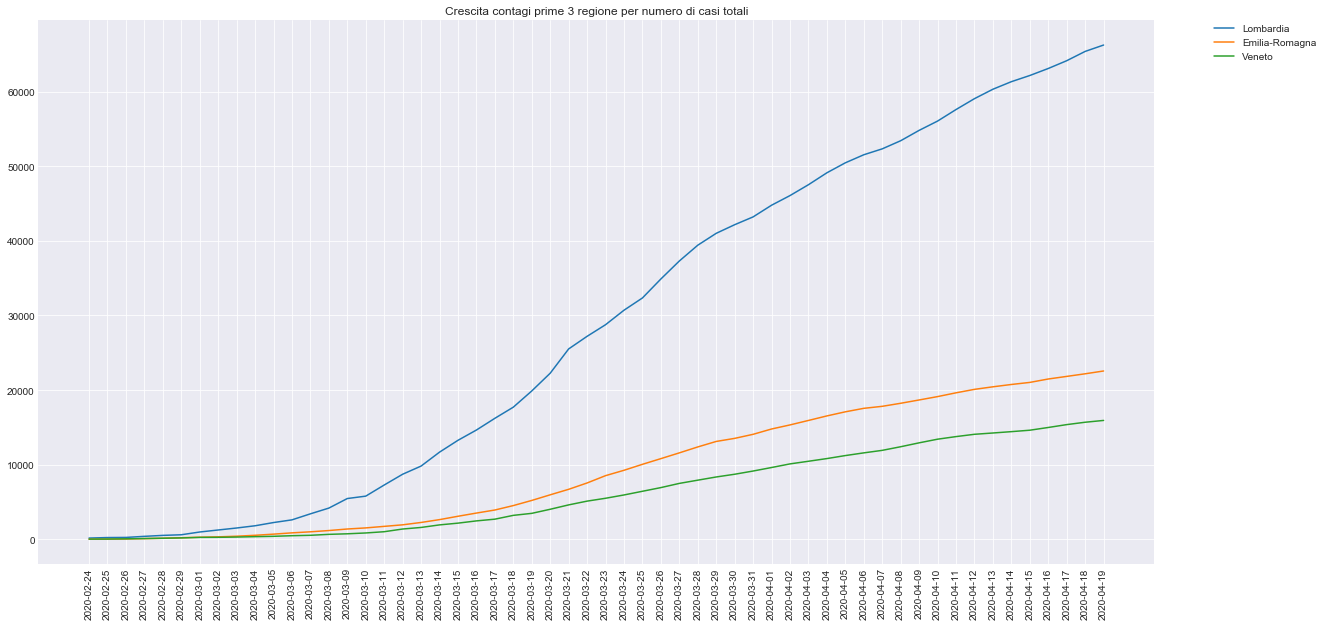

In [6]:
x=naz['date']
plt.subplots(figsize=(20,10))
plt.plot(x,cronologia_primi_tre_contagi[0], label=primi_tre[0])
plt.plot(x,cronologia_primi_tre_contagi[1], label=primi_tre[1])
plt.plot(x,cronologia_primi_tre_contagi[2], label=primi_tre[2])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Crescita contagi prime 3 regione per numero di casi totali')
plt.xticks(rotation='vertical')
plt.show()

Confronto contagi/tamponi effettuati per le prime 3 regioni più colpite


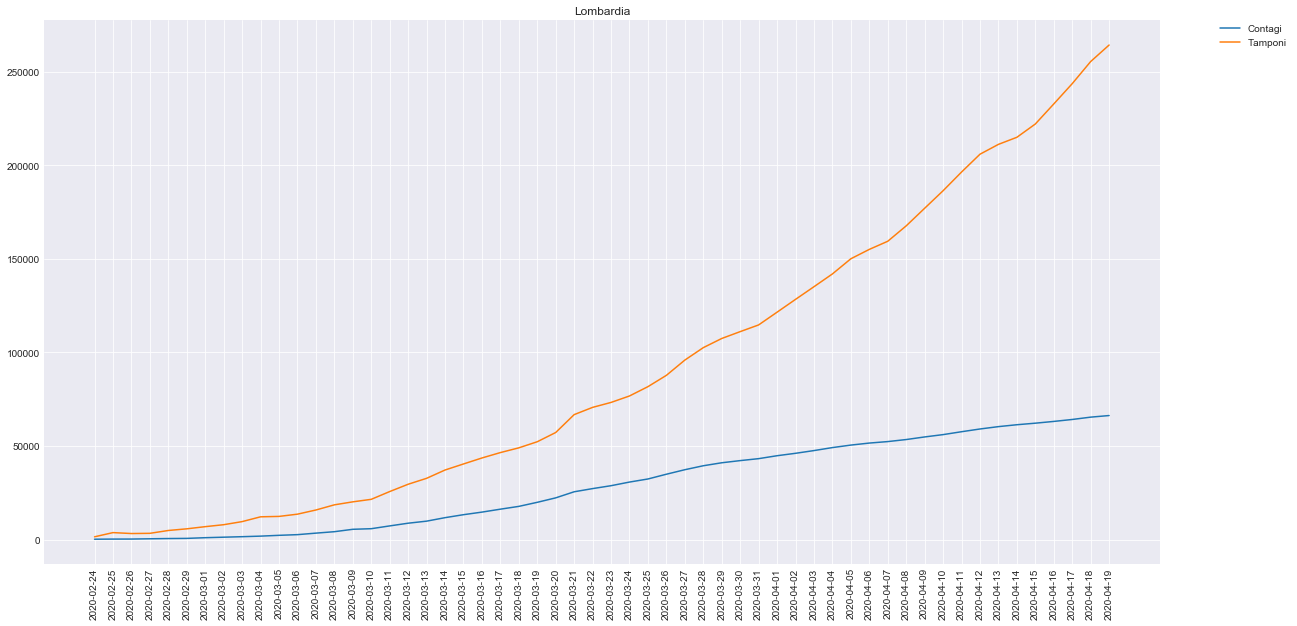

In [7]:
x=naz['date']
print('Confronto contagi/tamponi effettuati per le prime 3 regioni più colpite')
plt.subplots(figsize=(20,10))
plt.plot(x,cronologia_primi_tre_contagi[0], label='Contagi')
plt.plot(x,cronologia_primi_tre_tamponi[0], label='Tamponi')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title(primi_tre[0])
plt.xticks(rotation='vertical')
plt.show()

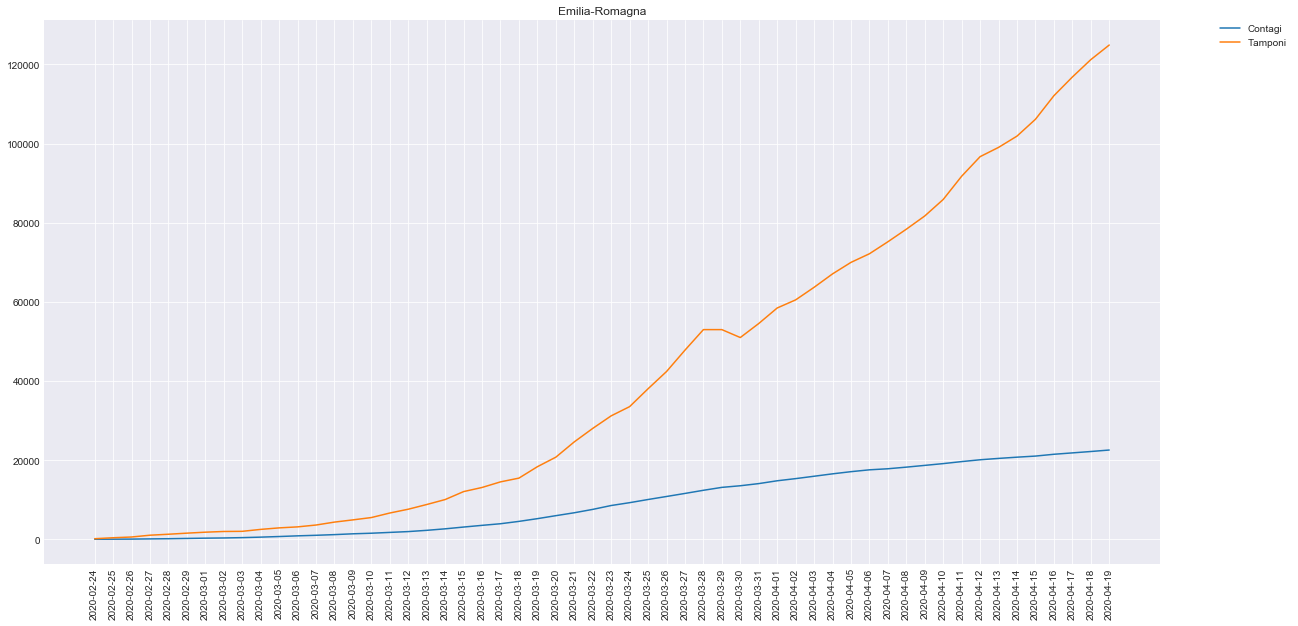

In [8]:
x=naz['date']
plt.subplots(figsize=(20,10))
plt.plot(x,cronologia_primi_tre_contagi[1], label='Contagi')
plt.plot(x,cronologia_primi_tre_tamponi[1], label='Tamponi')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title(primi_tre[1])
plt.xticks(rotation='vertical')
plt.show()

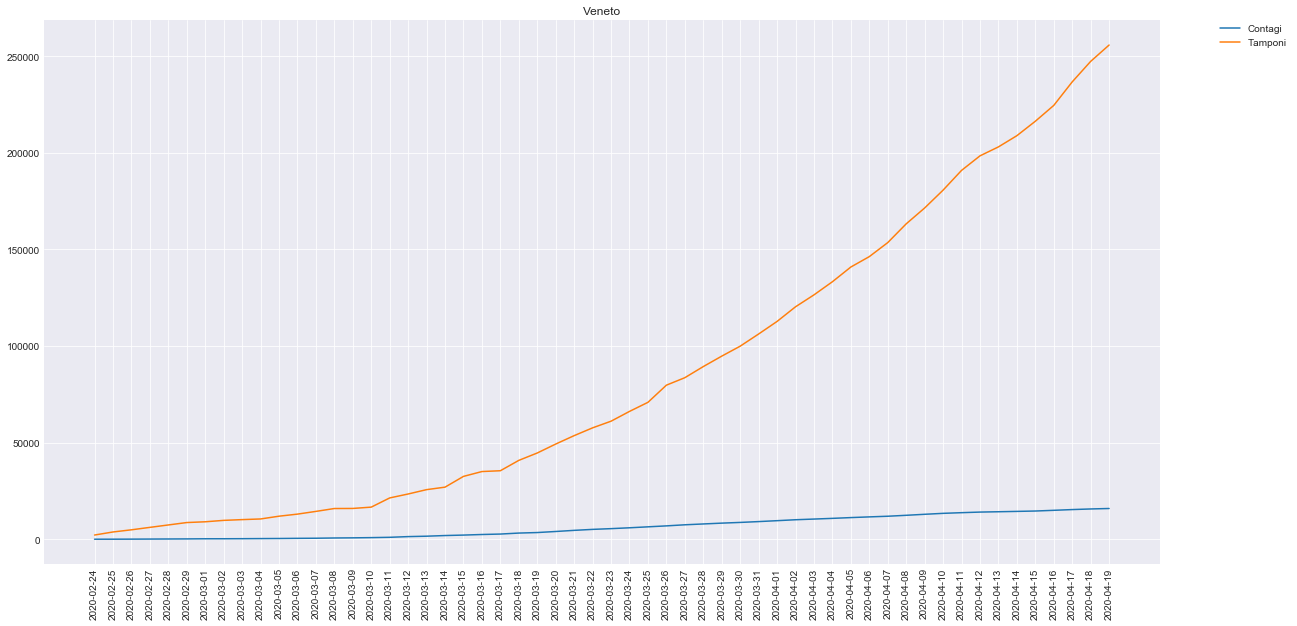

In [9]:
x=naz['date']
plt.subplots(figsize=(20,10))
plt.plot(x,cronologia_primi_tre_contagi[2], label='Contagi')
plt.plot(x,cronologia_primi_tre_tamponi[2], label='Tamponi')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title(primi_tre[2])
plt.xticks(rotation='vertical')
plt.show()

In [10]:
last_date=prov.loc[prov.shape[0]-1]['date']#ottengo data dell'ultima registrazione
prima_regione=primi_tre[0]#ottengo nome della prima regione per casi

provv=prov.copy()

indexNames = provv[ provv['date'] != last_date ].index
provv.drop(indexNames , inplace=True)#droppo tutte le righe che non hanno la data pari all'ultimo record

indexNames = provv[ provv['region_name'] != prima_regione ].index
provv.drop(indexNames , inplace=True)#droppo tutte le righe che non hanno la regione pari alla prima provincia

province=[x for x in provv.province_name]#genero liste contenenti i dati dell'ultima data
casi=[x for x in provv.total_cases]

comb=combina(province, casi)#ottengo lista contenente la coppia provincia-contagiati
comb=sorted(comb, key = itemgetter(1))#ordino la lista

provv=prov.copy()

primi_tre_prov=[comb[-1][0], comb[-2][0], comb[-3][0]]#memorizzo le prime 3 province colpite

cronologia_prime_tre_prov_contagi=crono_contagi_prov(provv, primi_tre_prov)

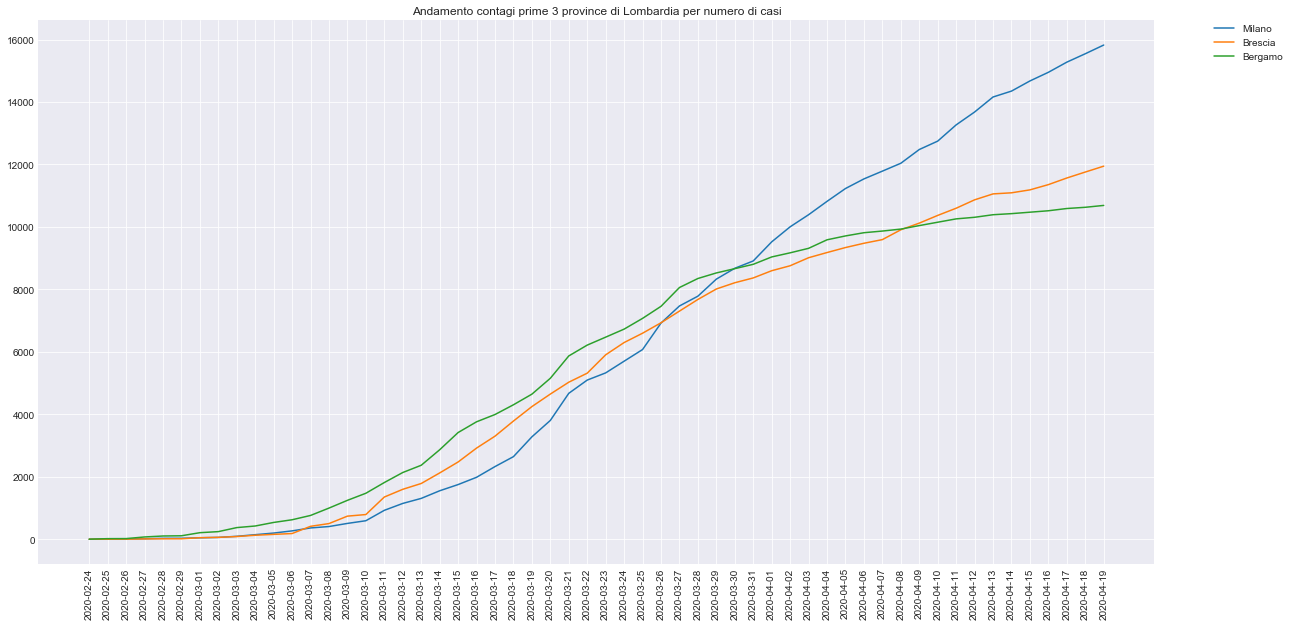

In [11]:
x=naz['date']
plt.subplots(figsize=(20,10))
plt.plot(x,cronologia_prime_tre_prov_contagi[0], label=primi_tre_prov[0])
plt.plot(x,cronologia_prime_tre_prov_contagi[1], label=primi_tre_prov[1])
plt.plot(x,cronologia_prime_tre_prov_contagi[2], label=primi_tre_prov[2])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
titolo="Andamento contagi prime 3 province di "+prima_regione+" per numero di casi"
plt.title(titolo)
plt.xticks(rotation='vertical')
plt.show()

In [12]:
data_campione=reg.loc[0]['date']#ottengo una data per isolare i dati di un giorno solo in modo tale da a vere una sola riga per regione

regg=reg.copy()

indexNames = regg[ regg['date'] != data_campione ].index
regg.drop(indexNames , inplace=True)#droppo tutte le righe che non hanno la data pari alla data campione

nomi_regioni=[x for x in regg.region_name]#genero lista contenente i nomi delle varie regioni

regg=reg.copy()

crono_contagi_regioni_giorno=crono_contagi_giorno(regg, nomi_regioni)#lista di liste contenente la cronologia dei contagi regione per regione seguendo l'ordine dei nomi presenti in nomi_regioni

media_contagi_reg=media_contagi_giorno(crono_contagi_regioni_giorno)

comm=combina(nomi_regioni, media_contagi_reg)#ottengo lista contenente la coppia regione-contagiati medi per giorno
comm=sorted(comm, key = itemgetter(1))#ordino la lista

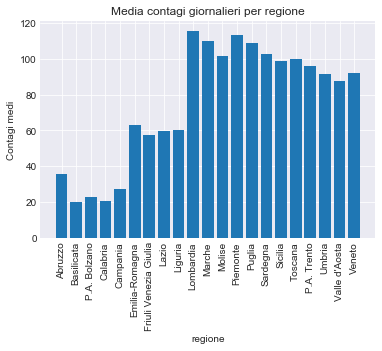

In [13]:
plt.xticks(rotation='vertical')
x_pos = np.arange(len(nomi_regioni))
plt.bar(x_pos, media_contagi_reg, align='center')
plt.xticks(x_pos, nomi_regioni)
plt.ylabel('Contagi medi')
plt.xlabel('regione')
plt.title('Media contagi giornalieri per regione')
plt.show()

In [14]:
print('Classifica contagi medi giornalieri per regione:')
classifica_contagi(comm)

Classifica contagi medi giornalieri per regione:
1 )  Lombardia :  115.49
2 )  Piemonte :  113.38
3 )  Marche :  110.16
4 )  Puglia :  108.84
5 )  Sardegna :  102.61
6 )  Molise :  101.3
7 )  Toscana :  99.67
8 )  Sicilia :  98.65
9 )  P.A. Trento :  96.09
10 )  Veneto :  91.87
11 )  Umbria :  91.44
12 )  Valle d'Aosta :  87.37
13 )  Emilia-Romagna :  63.1
14 )  Liguria :  60.21
15 )  Lazio :  59.95
16 )  Friuli Venezia Giulia :  57.49
17 )  Abruzzo :  35.48
18 )  Campania :  27.38
19 )  P.A. Bolzano :  22.62
20 )  Calabria :  20.73
21 )  Basilicata :  19.95


In [15]:
prima_regione=comm[-1][0]#ottengo nome della prima regione per casi medi a giorno
#prima_regione
data_campione=prov.loc[0]['date']#ottengo una data per isolare i dati di un giorno solo in modo tale da a vere una sola riga per regione
#print(data_campione)

provv=prov.copy()

indexNames = provv[ provv['date'] != data_campione ].index
provv.drop(indexNames , inplace=True)#droppo tutte le righe che non hanno la data pari alla data campione

indexNames = provv[ provv['region_name'] != prima_regione ].index
provv.drop(indexNames , inplace=True)#droppo tutte le righe che non hanno la regione pari alla prima provincia

province=[x for x in provv.province_name]#genero lista contenente i nomi delle province della prima regione

provv=prov.copy()

indexNames = provv[ provv['region_name'] != prima_regione ].index
provv.drop(indexNames , inplace=True)#droppo tutte le righe che non hanno la regione pari alla prima provincia


cronologia_contagi_provincia=crono_contagi_prov_giorno(provv, province)#lista di liste contenente la cronologia dei contagi provincia per regione seguendo l'ordine dei nomi presenti in nomi_regioni

#print(cronologia_contagi_provincia)

media_contagi_prov=media_contagi_giorno(cronologia_contagi_provincia)

combinato_p=combina(province, media_contagi_prov)#ottengo lista contenente la coppia regione-contagiati medi per giorno

combinato_p=sorted(combinato_p, key = itemgetter(1))#ordino la lista

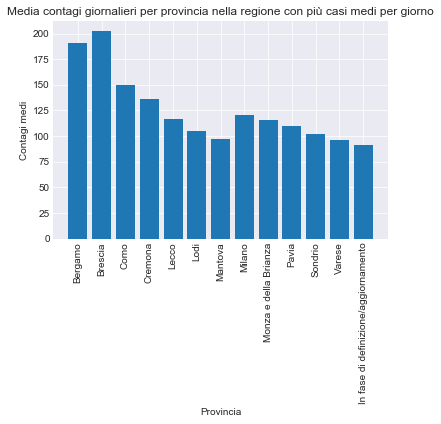

In [16]:
plt.xticks(rotation='vertical')
x_pos = np.arange(len(province))
plt.bar(x_pos, media_contagi_prov, align='center')
plt.xticks(x_pos, province)
plt.ylabel('Contagi medi')
plt.xlabel('Provincia')
title="Media contagi giornalieri per provincia nella regione con più casi medi per giorno"
plt.title(title)
plt.show()

In [17]:
print('Classifica contagi medi giornalieri per provincia:')
classifica_contagi(combinato_p)

Classifica contagi medi giornalieri per provincia:
1 )  Brescia :  202.1
2 )  Bergamo :  190.88
3 )  Como :  149.54
4 )  Cremona :  136.34
5 )  Milano :  120.68
6 )  Lecco :  116.47
7 )  Monza e della Brianza :  115.4
8 )  Pavia :  110.26
9 )  Lodi :  105.17
10 )  Sondrio :  101.79
11 )  Mantova :  97.55
12 )  Varese :  96.52
13 )  In fase di definizione/aggiornamento :  90.98


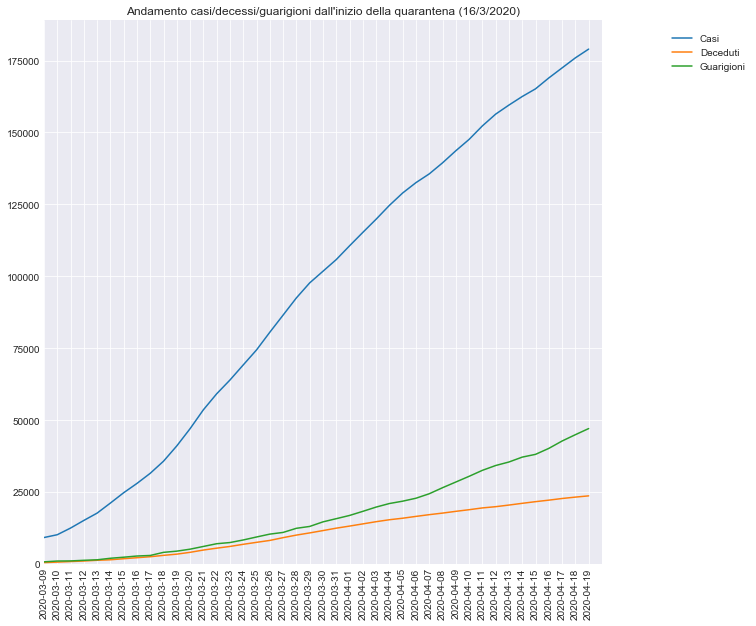

In [18]:
#analisi aumento quarantena con aumento infetti in ambito nazionale confrontati con decessi e guarigioni
#andamento contagi nazionali da lockdown(16-3)
plt.style.use('seaborn-darkgrid')
plt.subplots(figsize=(10,10))
plt.plot(naz['date'],naz["cumulative_cases"], label="Casi")
plt.plot(naz['date'],naz['death'], label="Deceduti")
plt.plot(naz['date'],naz['recovered'], label="Guarigioni")
limy=naz.loc[naz.shape[0]-1]['cumulative_cases']+10000 
entx=naz.loc[14]['date'] #imposto valore iniziale asse x
limx=len(naz['date'])#imposto valore finale asse x
# entx e limx prenderanno i valori nell'interavallo
plt.xlim(entx, limx)
plt.ylim(0,limy)#imposto limite asse y
plt.xticks(rotation='vertical')
plt.margins(2)
plt.title("Andamento casi/decessi/guarigioni dall'inizio della quarantena (16/3/2020)")
plt.legend(bbox_to_anchor=(1.10,1),loc='upper left', borderaxespad=1.)
plt.show()

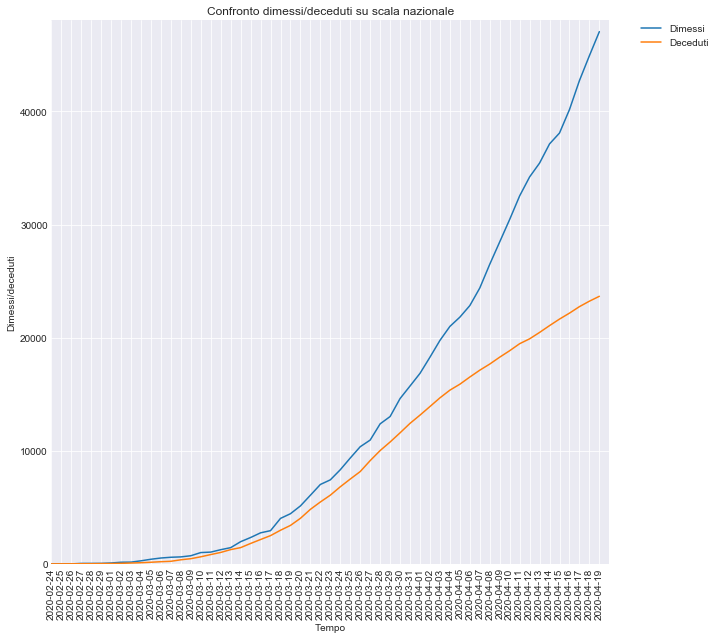

In [19]:
#confronto nazionale dimessi_guariti deceduti
plt.style.use('seaborn-darkgrid')
#plt.style.use('ggplot')
plt.subplots(figsize=(10,10))
plt.plot(naz['date'],naz['recovered'], label='Dimessi')
plt.plot(naz['date'],naz['death'], label='Deceduti')
limy=naz.loc[naz.shape[0]-1]['recovered']+1000 ###############fare circoletto che calcola il valore maggiore e poi applica il +1000
plt.xlim(0,len(naz)) #imposto grandezze asse x
plt.ylim(0,limy) #imposto grandezze asse y
plt.xticks(rotation='vertical') #ruoto i label asse x
plt.margins(2)
plt.ylabel('Dimessi/deceduti')
plt.xlabel('Tempo')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Confronto dimessi/deceduti su scala nazionale')
plt.show()

Riguardo l'andamento di decessi e guarigioni si vede che il numero di guarigioni cresce molto di più rispetto al numero di decessi con un valore medio praticamente il doppio rispetto al valore medio dei morti e si inizia a intravedere una stabilizzazione per il numero dei morti, sempre di meno ogni giorno

In [20]:
#media dimessi deceduti giornaliera nazionale
decessi=[x for x in naz.death]
dimessi=[x for x in naz.recovered]
m_decessi=media_decessi_giorno(decessi)
m_dimessi=media_decessi_giorno(dimessi)
print('Media giornaliera di morti: ',m_decessi)
print('Media giornaliera di dimissioni: ',m_dimessi)

Media giornaliera di morti:  422.5
Media giornaliera di dimissioni:  840.27


In [21]:
last_date=reg.loc[reg.shape[0]-1]['date']#ottengo data dell'ultima registrazione

regg=reg.copy()

indexNames = regg[ regg['date'] != last_date ].index
regg.drop(indexNames , inplace=True)#droppo tutte le righe che non hanno la data pari all'ultimo record

regioni=[x for x in regg.region_name]#genero liste contenenti i dati dell'ultima data
deceduti=[x for x in regg.death]

combinato=combina(regioni, deceduti)#ottengo lista contenente la coppia regione-decessi
combinato=sorted(combinato, key = itemgetter(1))#ordino la lista

#print(combinato)

regg=reg.copy()

primi_tre=[combinato[-1][0], combinato[-2][0], combinato[-3][0]]#memorizzo le prime 3 regioni per numero di deceduti

cronologia_primi_tre_deceduti=crono_deceduti(regg, primi_tre)#array ocntenente la cronologia di crescita dei deceduti nelle 3 regioni

cronologia_primi_tre_dimessi=crono_dimessi(regg, primi_tre)#array contenente la cronologia di crescita dei guariti nelle prime 3 regioni colpite



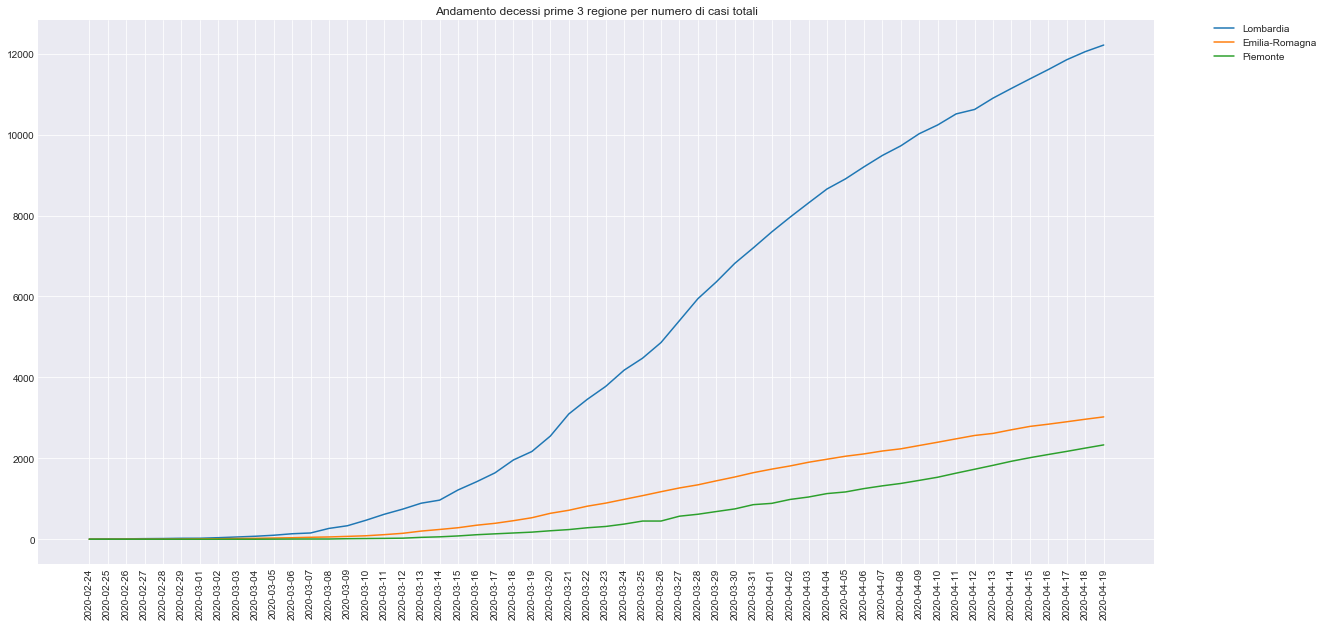

In [22]:
x=naz['date']
plt.subplots(figsize=(20,10))
plt.plot(x,cronologia_primi_tre_deceduti[0], label=primi_tre[0])
plt.plot(x,cronologia_primi_tre_deceduti[1], label=primi_tre[1])
plt.plot(x,cronologia_primi_tre_deceduti[2], label=primi_tre[2])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Andamento decessi prime 3 regione per numero di casi totali')
plt.xticks(rotation='vertical')
plt.show()

Confronto decessi/dimissioni per le prime 3 regioni più colpite


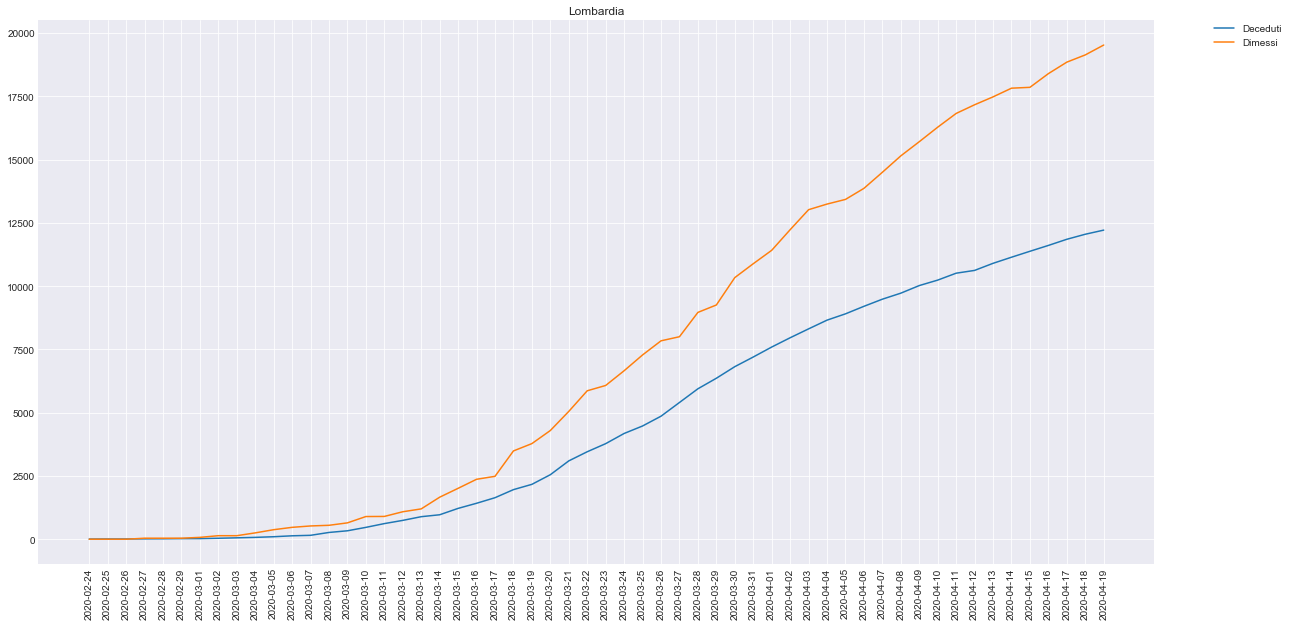

In [23]:
x=naz['date']
print('Confronto decessi/dimissioni per le prime 3 regioni più colpite')
plt.subplots(figsize=(20,10))
plt.plot(x,cronologia_primi_tre_deceduti[0], label='Deceduti')
plt.plot(x,cronologia_primi_tre_dimessi[0], label='Dimessi')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title(primi_tre[0])
plt.xticks(rotation='vertical')
plt.show()

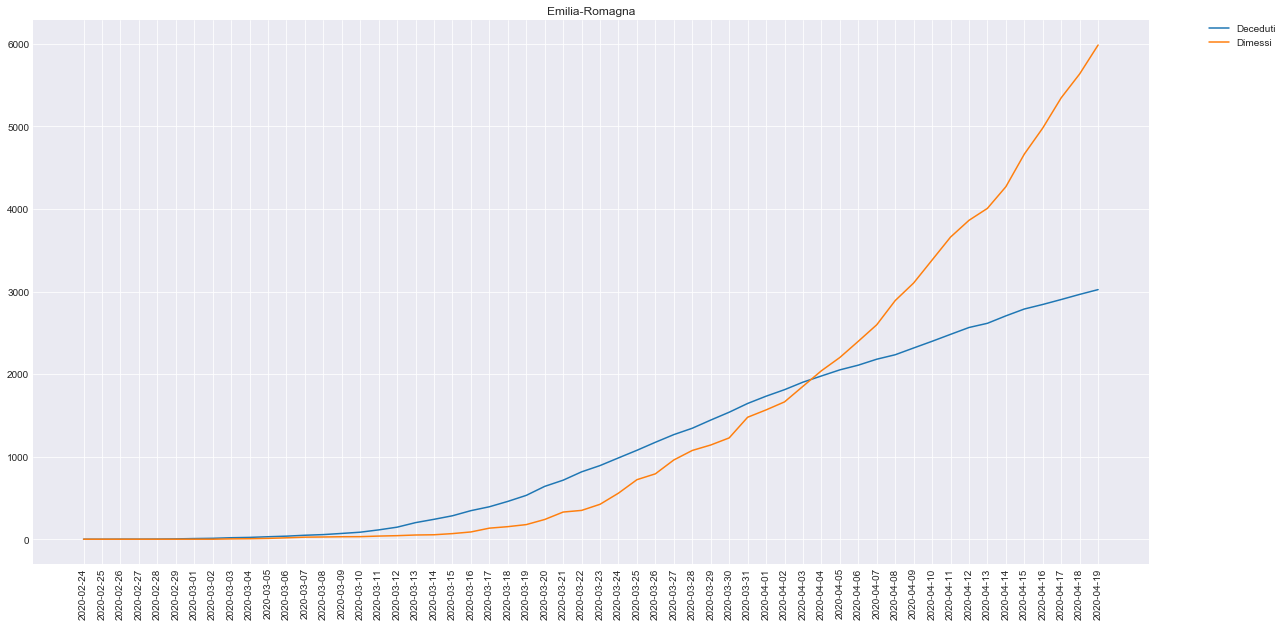

In [24]:
x=naz['date']
plt.subplots(figsize=(20,10))
plt.plot(x,cronologia_primi_tre_deceduti[1], label='Deceduti')
plt.plot(x,cronologia_primi_tre_dimessi[1], label='Dimessi')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title(primi_tre[1])
plt.xticks(rotation='vertical')
plt.show()

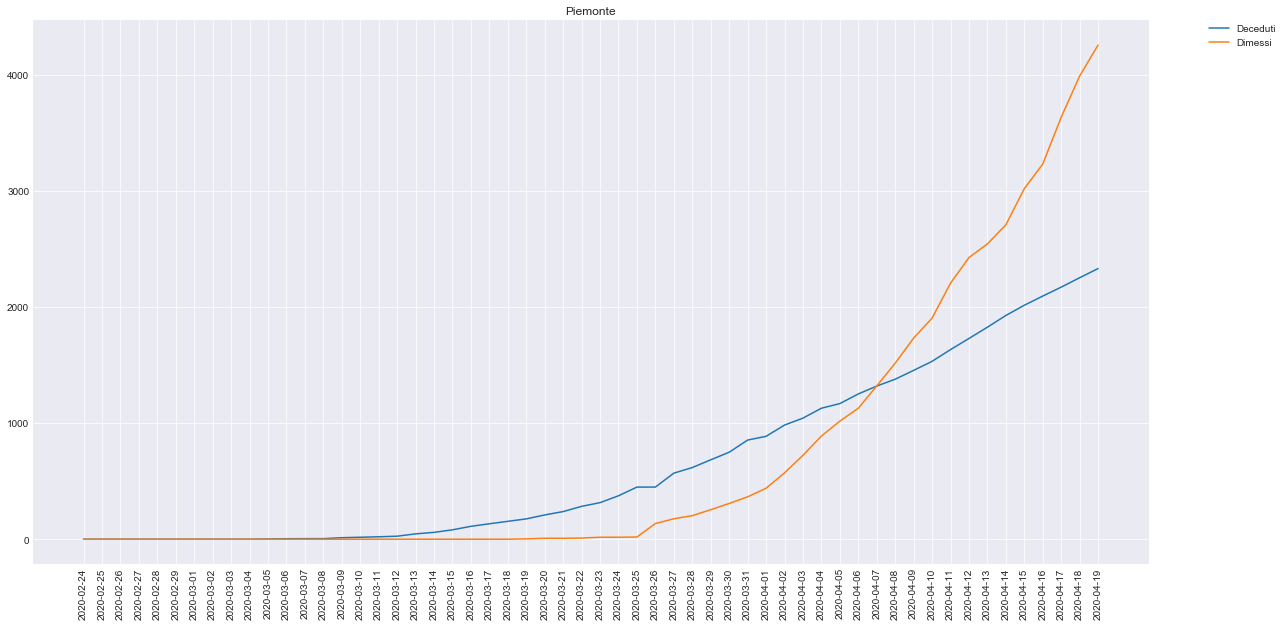

In [25]:
x=naz['date']
plt.subplots(figsize=(20,10))
plt.plot(x,cronologia_primi_tre_deceduti[2], label='Deceduti')
plt.plot(x,cronologia_primi_tre_dimessi[2], label='Dimessi')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title(primi_tre[2])
plt.xticks(rotation='vertical')

plt.show()

In [26]:
globb=glob.copy() #copio il dataset globale
globb= globb.loc[glob.Country_Region=="Mainland China"] #estraggo le righe con stato uguale a Cina
globb.fillna(0, inplace=True) #sostituisco i NaN con 0
stato=[]
date=[x for x in globb['ObservationDate']]   #creo una lista con le date
province=[x for x in globb['Province_State']] #creo una lista con le province
contagiati=[x for x in globb['Confirmed']] #creo una lista con i contagiati
#creo una lista con solo scritto CHI in riferimento allo stato
for x in range(len(province)):
    stato.append("CHI")  
#unisco le liste in una lista di lista
province_contagiati_data=combina_4(date,stato, province, contagiati)
chi = pd.DataFrame.from_records(province_contagiati_data)#creo dataset con lista di lista
chi.columns = ["date","state", "region_name", "cumulative_cases"]#allego le colonne
chi['cumulative_cases']=chi['cumulative_cases'].apply(np.int64) #trasformo i float in int
#chi

In [27]:
#andamento contagio per le 3 regioni più colpite della cina
last_date=chi.loc[chi.shape[0]-1]['date']#ottengo data dell'ultima registrazione

chii=chi.copy()

indexNames = chii[ chii['date'] != last_date ].index
chii.drop(indexNames , inplace=True)#droppo tutte le righe che non hanno la data pari all'ultimo record

regione=[x for x in chii.region_name]#genero liste contenenti i dati dell'ultima data
casi=[x for x in chii.cumulative_cases]

combinato=combina(regione, casi)#ottengo lista contenente la coppia regione-casi
combinato=sorted(combinato, key = itemgetter(1))#ordino la lista

#print(combinato)

chii=chi.copy()

primi_tre=[combinato[-1][0], combinato[-2][0], combinato[-3][0]]#memorizzo le prime 3 regioni per numero di deceduti

cronologia_primi_tre_contagi=crono_contagi(chii, primi_tre)#array ocntenente la cronologia di crescita dei deceduti nelle 3 regioni



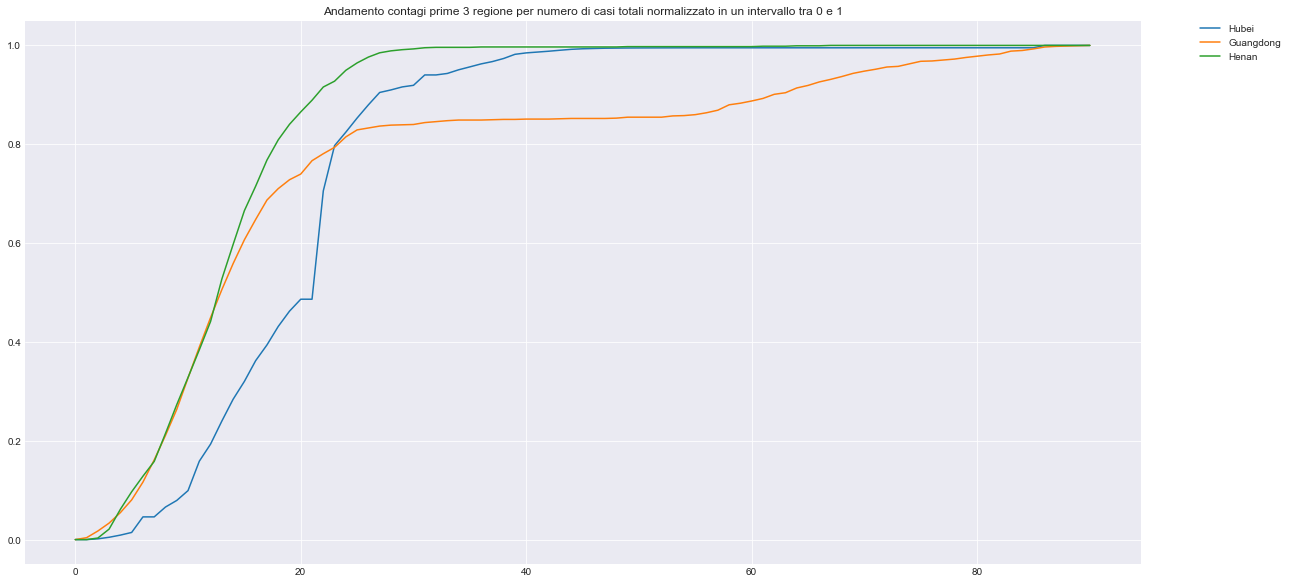

In [28]:
plt.subplots(figsize=(20,10))
plt.plot(normalizzatore(cronologia_primi_tre_contagi[0]), label=primi_tre[0])
plt.plot(normalizzatore(cronologia_primi_tre_contagi[1]), label=primi_tre[1])
plt.plot(normalizzatore(cronologia_primi_tre_contagi[2]), label=primi_tre[2])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Andamento contagi prime 3 regione per numero di casi totali normalizzato in un intervallo tra 0 e 1')
plt.show()

Confronto decessi/dimissioni per le prime 3 regioni più colpite


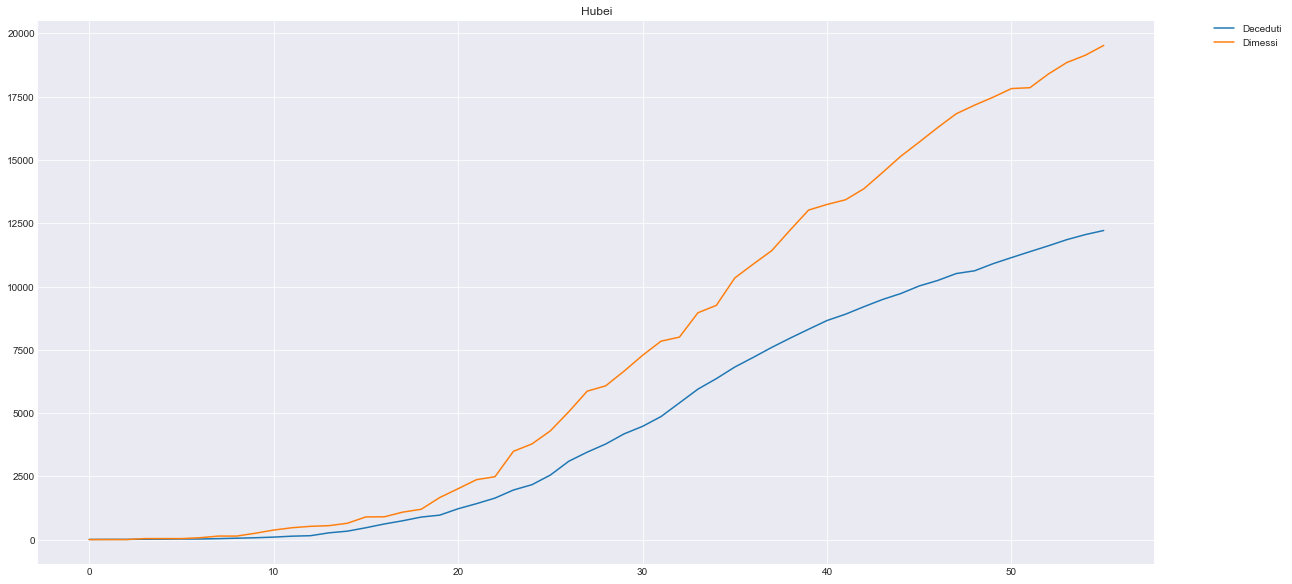

In [29]:
print('Confronto decessi/dimissioni per le prime 3 regioni più colpite')
plt.subplots(figsize=(20,10))
plt.plot(cronologia_primi_tre_deceduti[0], label='Deceduti')
plt.plot(cronologia_primi_tre_dimessi[0], label='Dimessi')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title(primi_tre[0])
plt.show()

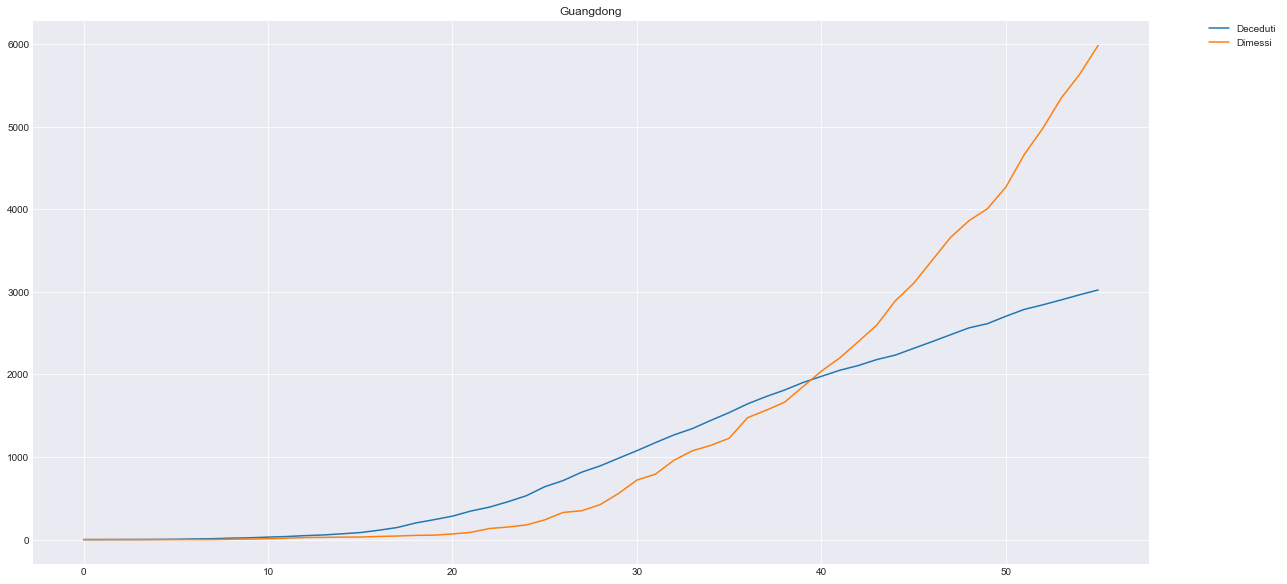

In [30]:
plt.subplots(figsize=(20,10))
plt.plot(cronologia_primi_tre_deceduti[1], label='Deceduti')
plt.plot(cronologia_primi_tre_dimessi[1], label='Dimessi')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title(primi_tre[1])
plt.show()

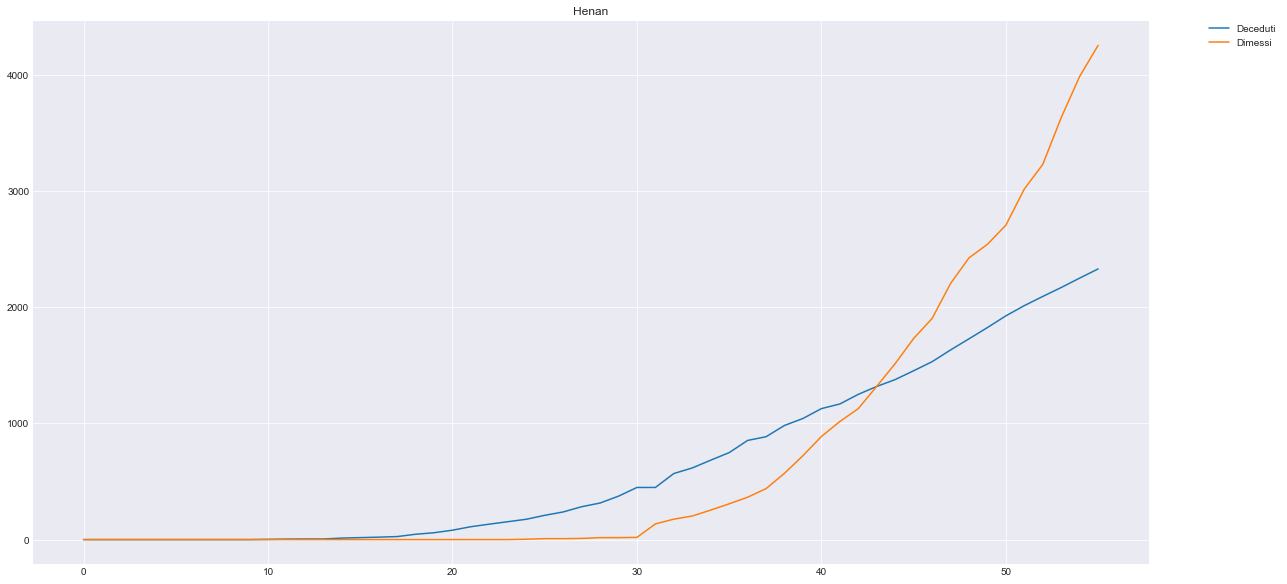

In [31]:
plt.subplots(figsize=(20,10))
plt.plot(cronologia_primi_tre_deceduti[2], label='Deceduti')
plt.plot(cronologia_primi_tre_dimessi[2], label='Dimessi')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title(primi_tre[2])
plt.show()

In [32]:
data_campione=chi.loc[0]['date']#ottengo una data per isolare i dati di un giorno solo in modo tale da a vere una sola riga per regione

chii=chi.copy()

indexNames = chii[ chii['date'] != data_campione ].index
chii.drop(indexNames , inplace=True)#droppo tutte le righe che non hanno la data pari alla data campione

nomi_regioni=[x for x in chii.region_name]#genero lista contenente i nomi delle varie regioni

chii=chi.copy()

crono_contagi_regioni=crono_contagi(chii, nomi_regioni)#lista di liste contenente la cronologia dei contagi regione per regione seguendo l'ordine dei nomi presenti in nomi_regioni

media_contagi_reg=media_contagi_giorno(crono_contagi_regioni)

comm=combina(nomi_regioni, media_contagi_reg)#ottengo lista contenente la coppia regione-contagiati medi per giorno
comm=sorted(comm, key = itemgetter(1))#ordino la lista

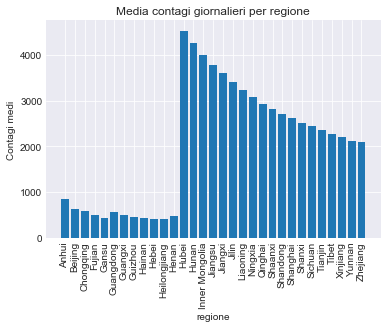

In [33]:
plt.xticks(rotation='vertical')
x_pos = np.arange(len(nomi_regioni))
plt.bar(x_pos, media_contagi_reg, align='center')
plt.xticks(x_pos, nomi_regioni)
plt.ylabel('Contagi medi')
plt.xlabel('regione')
plt.title('Media contagi giornalieri per regione')
plt.show()

In [34]:
print('Classifica contagi medi giornalieri per regione:')
classifica_contagi(comm)

Classifica contagi medi giornalieri per regione:
1 )  Hubei :  4528.34
2 )  Hunan :  4268.34
3 )  Inner Mongolia :  3990.16
4 )  Jiangsu :  3775.08
5 )  Jiangxi :  3600.24
6 )  Jilin :  3405.15
7 )  Liaoning :  3232.32
8 )  Ningxia :  3074.16
9 )  Qinghai :  2928.84
10 )  Shaanxi :  2805.73
11 )  Shandong :  2710.78
12 )  Shanghai :  2613.26
13 )  Shanxi :  2513.82
14 )  Sichuan :  2434.95
15 )  Tianjin :  2349.62
16 )  Tibet :  2271.21
17 )  Xinjiang :  2195.01
18 )  Yunnan :  2126.96
19 )  Zhejiang :  2092.98
20 )  Anhui :  839.23
21 )  Beijing :  627.87
22 )  Chongqing :  585.04
23 )  Guangdong :  556.86
24 )  Guangxi :  508.41
25 )  Fujian :  507.34
26 )  Henan :  467.49
27 )  Guizhou :  460.22
28 )  Hainan :  425.18
29 )  Gansu :  424.41
30 )  Heilongjiang :  411.5
31 )  Hebei :  408.39


Riguardo l'andamento della curva di crescita dei casi totali in Cina per le prime 3 regioni colpite si evince che la curva di crescita ha iniziato a stabilizzarsi

In [35]:
chitaa=chita.copy()
cina=chitaa.loc[0]['Stato']
indexNames=chitaa[chitaa['Stato']!=cina].index
chitaa.drop(indexNames, inplace=True)#droppo tutte le righe che non sono la cina

cinesi=[x for x in chitaa.Regione]#nomi regioni cinesi
dens_cina=[x for x in chitaa.Densita]#densità regioni cinesi
pil_cina=[x for x in chitaa.PIL]#pil regioni cinesi

In [36]:
chitaa=chita.copy()

italia=chitaa.loc[chitaa.shape[0]-1]['Stato']
indexNames=chitaa[chitaa['Stato']!=italia].index
chitaa.drop(indexNames, inplace=True)#droppo tutte le righe che non sono la cina

italiani=[x for x in chitaa.Regione]#nomi regioni cinesi
dens_italia=[x for x in chitaa.Densita]#densità regioni cinesi
pil_italia=[x for x in chitaa.PIL]#pil regioni cinesi

In [37]:
comb_cina=combina_3(cinesi,dens_cina,pil_cina)#ottengo lista contenente il trio regione, densità, pil
comb_italia=combina_3(italiani, dens_italia, pil_italia)

In [38]:
#confronto densità
comb_cina=sorted(comb_cina, key = itemgetter(1))#ordino la lista per il secondo elemento
comb_italia=sorted(comb_italia, key = itemgetter(1))#ordino la lista per il secondo elemento

In [39]:
#estraggo regione più densa
dens_cina=[comb_cina[-1][0]]#metto in una lista così non devo creare un metodo apposta per questa estrazione di cronologia
dens_italia=[comb_italia[-1][0]]

In [40]:
crono_cont_ita=crono_contagi(regg, dens_italia)#array ocntenente la cronologia di crescita dei deceduti nelle 3 regioni
chii=chi.copy()
crono_cont_cina=crono_contagi(chii, dens_cina)#array ocntenente la cronologia di crescita dei deceduti nelle 3 regioni

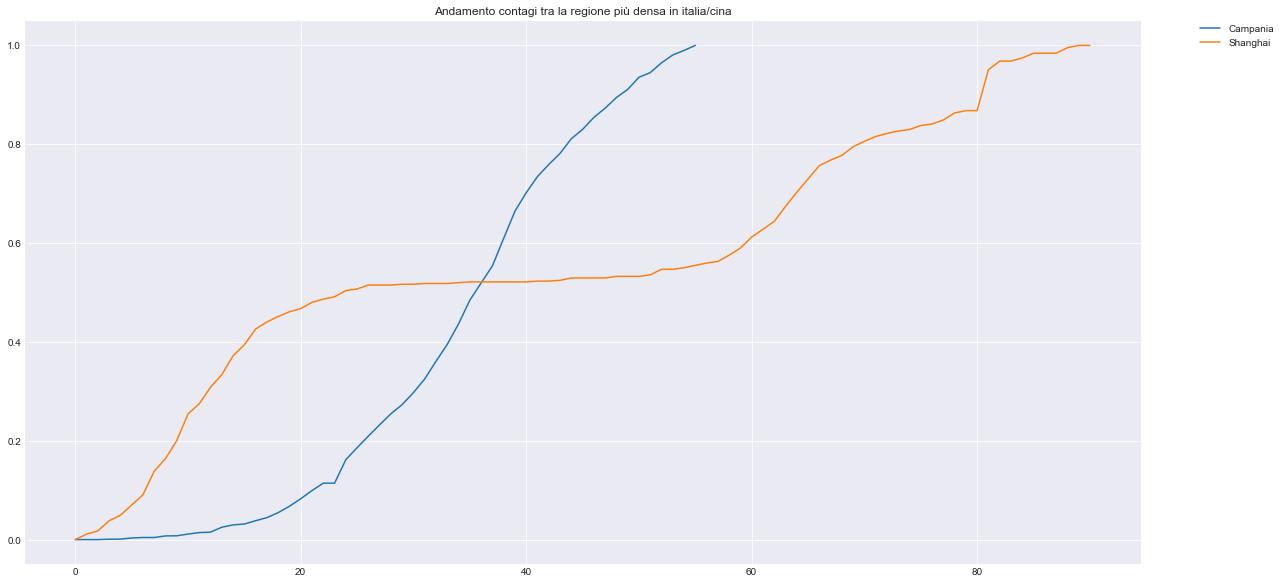

I dati cinesi partono da molto prima dei rilevamenti in italia


In [41]:
plt.subplots(figsize=(20,10))
plt.plot(normalizzatore(crono_cont_ita[0]), label=dens_italia[0])
plt.plot(normalizzatore(crono_cont_cina[0]), label=dens_cina[0])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Andamento contagi tra la regione più densa in italia/cina')
plt.show()
print("I dati cinesi partono da molto prima dei rilevamenti in italia")

Riguardo la curva di crescita nelle regioni più dense per Italia e Cina si nota che la curva di crescita cinese ha iniziato a stabilizzarsi per poi riprendere la crescita mentre quella italiana no

In [42]:
#confronto pil
comb_cina=sorted(comb_cina, key = itemgetter(2))#ordino la lista per il secondo elemento
comb_italia=sorted(comb_italia, key = itemgetter(2))#ordino la lista per il secondo elemento

In [43]:
#estraggo regione con pil più alto
pil_cina=[comb_cina[-1][0]]#metto in una lista così non devo creare un metodo apposta per questa estrazione di cronologia
pil_italia=[comb_italia[-1][0]]

In [44]:
crono_cont_ita=crono_contagi(regg, pil_italia)#array ocntenente la cronologia di crescita dei deceduti nelle 3 regioni
chii=chi.copy()
crono_cont_cina=crono_contagi(chii, pil_cina)#array ocntenente la cronologia di crescita dei deceduti nelle 3 regioni

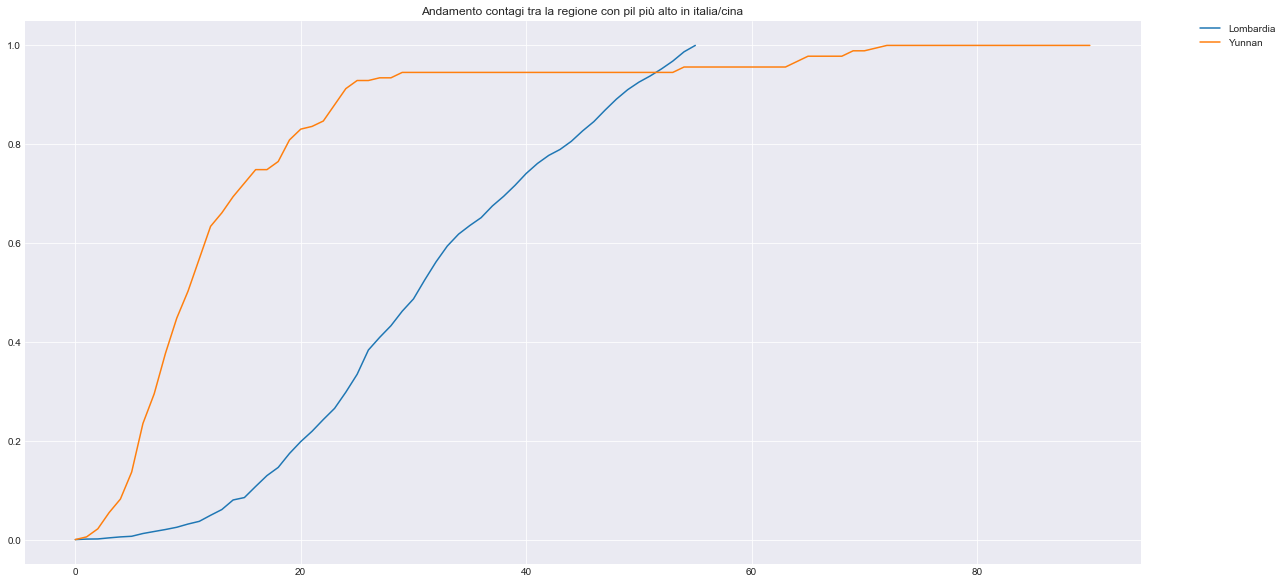

I dati cinesi partono da molto prima dei rilevamenti in italia


In [45]:
plt.subplots(figsize=(20,10))
plt.plot(normalizzatore(crono_cont_ita[0]), label=pil_italia[0])
plt.plot(normalizzatore(crono_cont_cina[0]), label=pil_cina[0])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Andamento contagi tra la regione con pil più alto in italia/cina')
plt.show()
print("I dati cinesi partono da molto prima dei rilevamenti in italia")

Dal grafico si evince che la stabilizzazione della crescita dei contagi per la regione cinese con il PIL più alto ha iniziato a stabilizzarsi dopo non molto tempo dal primo contagio

In [46]:
#CONFRONTO REGIONI ITALIANE IN SCALA NORMALIZZATA

In [47]:
comb_italia=sorted(comb_italia, key = itemgetter(1))#ordino la lista per densità

In [48]:
reg_d_top=comb_italia[-1][0]#regione più densa
reg_d_mid1=comb_italia[12][0]#mediamente pil
reg_d_mid2=comb_italia[11][0]#mediamente pil
reg_d_mid3=comb_italia[10][0]#mediamente pil
reg_d_bot=comb_italia[0][0]#meno densa
reg_d=[reg_d_top,reg_d_mid1,reg_d_mid2,reg_d_mid3,reg_d_bot]

In [49]:
comb_italia=sorted(comb_italia, key = itemgetter(2))#ordino la lista per pil

In [50]:
reg_p_top=comb_italia[-1][0]#regione più pil
reg_p_mid1=comb_italia[12][0]#mediamente pil
reg_p_mid2=comb_italia[11][0]#mediamente pil
reg_p_mid3=comb_italia[10][0]#mediamente pil
reg_p_bot=comb_italia[0][0]#meno pil
reg_p=[reg_p_top,reg_p_mid1,reg_p_mid2,reg_p_mid3,reg_p_bot]

In [51]:
regg=reg.copy()
#ottengo crono contagi regioni per densità
crono_d=crono_contagi(regg,reg_d)
regg=reg.copy()
#ottengo crono contagi regioni per pil
crono_p=crono_contagi(regg, reg_p)

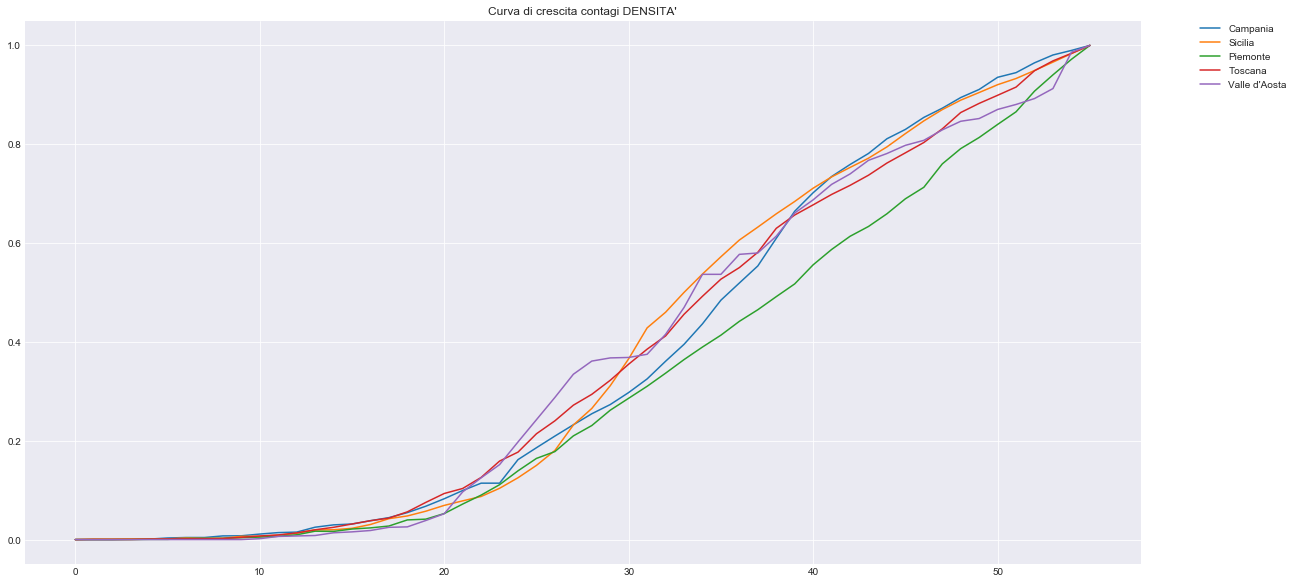

In [52]:
plt.subplots(figsize=(20,10))
plt.plot(normalizzatore(crono_d[0]), label=reg_d[0])
plt.plot(normalizzatore(crono_d[1]), label=reg_d[1])
plt.plot(normalizzatore(crono_d[2]), label=reg_d[2])
plt.plot(normalizzatore(crono_d[3]), label=reg_d[3])
plt.plot(normalizzatore(crono_d[4]), label=reg_d[4])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Curva di crescita contagi DENSITA\'')
plt.show()

Il grafico rappresenta la curva di crescita normalizzata dei contagi in base alla densità. Le regioni prese in riferimento sono la Campania (prima per densità), la Valle d'Aosta (ultima per densità) e 3 regioni con densità nella media. Si denota che non c'è una stretta correlazione tra densità e aumento della curva in quanto l'andamento è abbastanza simile per quasi tutte le regioni. Non possiamo parlare di numeri definiti in quanto lo scopo è di mostrare l'andamento della curva.
Ci si aspettava che la curva delle regioni più densamente popolate iniziasse a crescere prima rispetto a quelle meno dense.

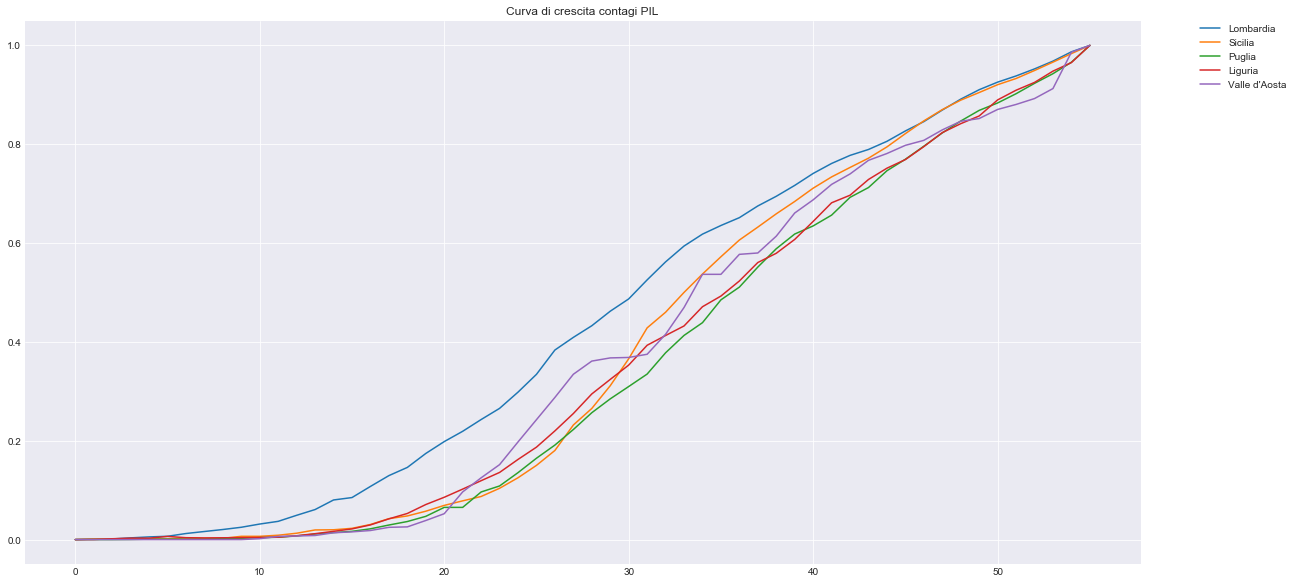

In [53]:
plt.subplots(figsize=(20,10))
plt.plot(normalizzatore(crono_p[0]), label=reg_p[0])
plt.plot(normalizzatore(crono_p[1]), label=reg_p[1])
plt.plot(normalizzatore(crono_p[2]), label=reg_p[2])
plt.plot(normalizzatore(crono_p[3]), label=reg_p[3])
plt.plot(normalizzatore(crono_p[4]), label=reg_p[4])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Curva di crescita contagi PIL')
plt.show()

Il grafico rappresenta la curva di crescita normalizzata dei contagi in base al PIL. Le regioni prese in riferimento sono la Lombardia (prima per valore PIL), la Valle d'Aosta (ultima per valore PIL) e tre regioni con valori medi (Sicilia, Puglia e Liguria). Si ipotizza che le regioni con valore del prodotto interno lordo alto, abbiano una capacità di gestire i contagi in maniera migliore (acquisto di farmaci, apparecchiature sanitarie e servizi vs la comunià). Il risultato del grafico non conferma l'ipotesi espressa. Il PIL concludendo non influisce sull'andamento dei contagi.
#ci aspettavamo un'impennata minore  per la Lombardia, mentre un'impennata maggiore per le regioni meno abbienti

In [54]:
regg=reg.copy()
#ottengo crono contagi regioni per densità
crono_d_giorno=crono_contagi_giorno(regg,reg_d)
regg=reg.copy()
#ottengo crono contagi regioni per pil
crono_p_giorno=crono_contagi_giorno(regg, reg_p)

In [55]:
#Creo dataframe d'appoggio per poter fare lo smoothing
d1=pd.DataFrame(crono_d_giorno[0],columns =['val'])
d2=pd.DataFrame(crono_d_giorno[1],columns =['val'])
d3=pd.DataFrame(crono_d_giorno[2],columns =['val'])
d4=pd.DataFrame(crono_d_giorno[3],columns =['val'])
d5=pd.DataFrame(crono_d_giorno[4],columns =['val'])

p1=pd.DataFrame(crono_p_giorno[0],columns =['val'])
p2=pd.DataFrame(crono_p_giorno[1],columns =['val'])
p3=pd.DataFrame(crono_p_giorno[2],columns =['val'])
p4=pd.DataFrame(crono_p_giorno[3],columns =['val'])
p5=pd.DataFrame(crono_p_giorno[4],columns =['val'])

In [56]:
#effettuo lo smoothing al 10%
loess_d1=pd.DataFrame(lowess(d1.val, np.arange(len(d1.val)), frac=0.10)[:, 1], index=d1.index, columns=['val'])
loess_d2=pd.DataFrame(lowess(d2.val, np.arange(len(d2.val)), frac=0.10)[:, 1], index=d2.index, columns=['val'])
loess_d3=pd.DataFrame(lowess(d3.val, np.arange(len(d3.val)), frac=0.10)[:, 1], index=d3.index, columns=['val'])
loess_d4=pd.DataFrame(lowess(d4.val, np.arange(len(d4.val)), frac=0.10)[:, 1], index=d4.index, columns=['val'])
loess_d5=pd.DataFrame(lowess(d5.val, np.arange(len(d5.val)), frac=0.10)[:, 1], index=d5.index, columns=['val'])

loess_p1=pd.DataFrame(lowess(p1.val, np.arange(len(p1.val)), frac=0.10)[:, 1], index=p1.index, columns=['val'])
loess_p2=pd.DataFrame(lowess(p2.val, np.arange(len(p2.val)), frac=0.10)[:, 1], index=p2.index, columns=['val'])
loess_p3=pd.DataFrame(lowess(p3.val, np.arange(len(p3.val)), frac=0.10)[:, 1], index=p3.index, columns=['val'])
loess_p4=pd.DataFrame(lowess(p4.val, np.arange(len(p4.val)), frac=0.10)[:, 1], index=p4.index, columns=['val'])
loess_p5=pd.DataFrame(lowess(p5.val, np.arange(len(p5.val)), frac=0.10)[:, 1], index=p5.index, columns=['val'])

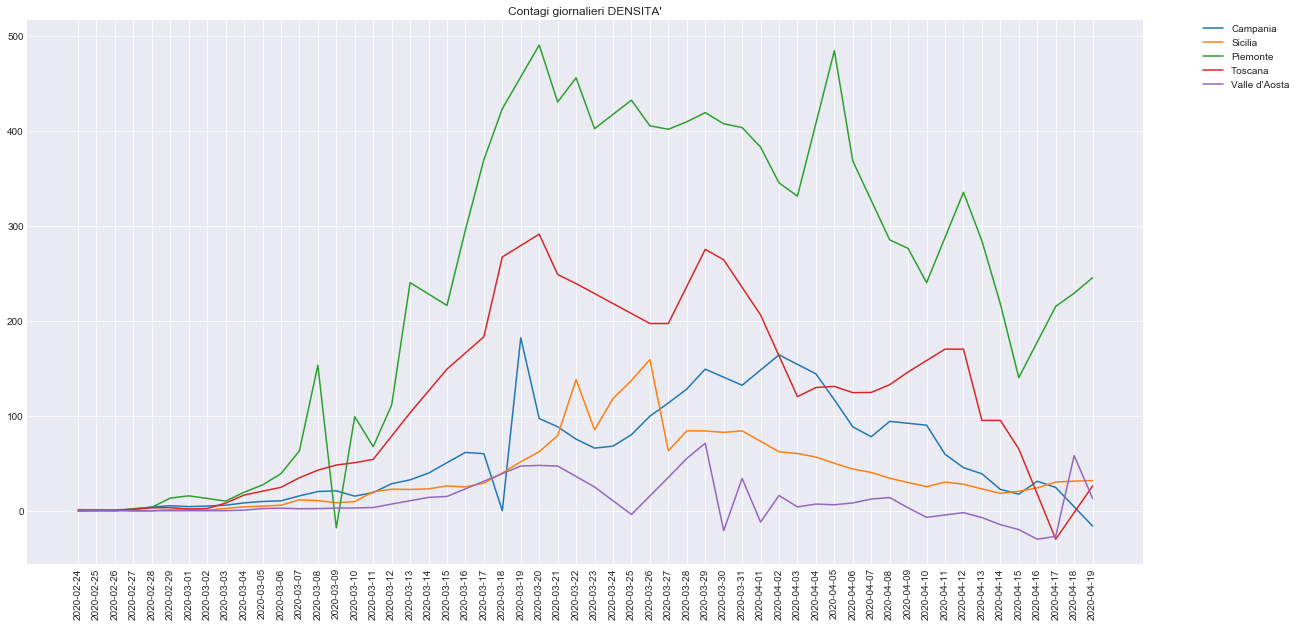

In [57]:
plt.subplots(figsize=(20,10))
plt.plot(naz['date'],loess_d1, label=reg_d[0])
plt.plot(naz['date'],loess_d2, label=reg_d[1])
plt.plot(naz['date'],loess_d3, label=reg_d[2])
plt.plot(naz['date'],loess_d4, label=reg_d[3])
plt.plot(naz['date'],loess_d5, label=reg_d[4])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Contagi giornalieri DENSITA\'')
plt.xticks(rotation='vertical')
plt.show()

Il grafico rappresenta i contagi giornalieri per le regioni in base alla loro densità demografica. Anche in questo caso, la densità non influisce sul numero dei contagi, in quanto come mostrato nel grafico, si nota che:
- La Campania ha un numero di contagi giornalieri minore alle regione con media densità
- La Valle d'Aosta rispecchia la correlazione ipotizzata. 

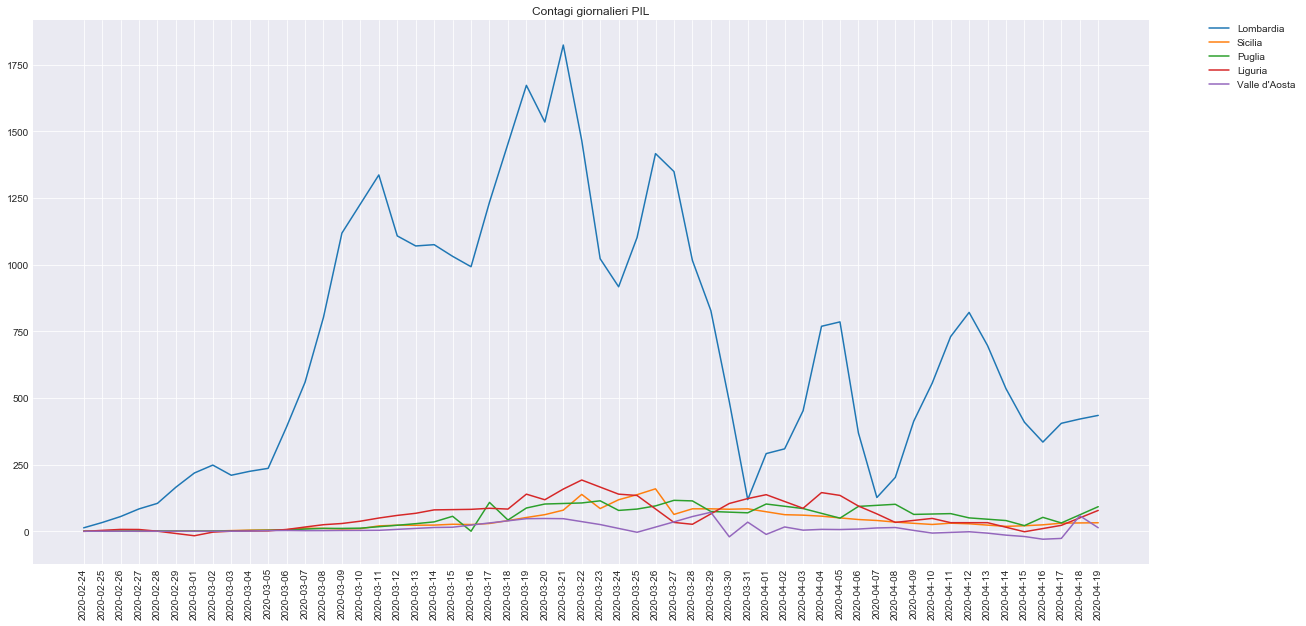

In [58]:
plt.subplots(figsize=(20,10))
plt.plot(naz['date'],loess_p1, label=reg_p[0])
plt.plot(naz['date'],loess_p2, label=reg_p[1])
plt.plot(naz['date'],loess_p3, label=reg_p[2])
plt.plot(naz['date'],loess_p4, label=reg_p[3])
plt.plot(naz['date'],loess_p5, label=reg_p[4])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Contagi giornalieri PIL')
plt.xticks(rotation='vertical')
plt.show()

La situazione è simile a quella della curva dei conatgi. Il grafico rappresenta il numero dei contagi giornalieri in base al PIL. Le regioni prese in riferimento sono la Lombardia (prima per valore PIL), la Valle d'Aosta (ultima per valore PIL) e tre regioni con valori medi (Sicilia, Puglia e Liguria). Si ipotizza che le regioni con valore del prodotto interno lordo alto, abbiano una capacità di gestire i contagi in maniera migliore (acquisto di farmaci, apparecchiature sanitarie e servizi vs la comunià). Il risultato del grafico non conferma l'ipotesi espressa. Il PIL, come già dichiarato, non influisce sull'andamento dei contagi.

#ci aspettavamo an andamento più lieve per la Lombardia, mentre più sostenuto per le regioni meno abbienti.

In [59]:
#Decomposizione df nazionale
nazz=naz.copy()
nazz.reset_index(inplace=True)
nazz['date']=pd.to_datetime(nazz['date'])
nazz=nazz.set_index('date')
dpc=sm.tsa.seasonal_decompose(nazz.daily_positive_cases)
cc=sm.tsa.seasonal_decompose(nazz.cumulative_cases)

C:\Users\Gianluca\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


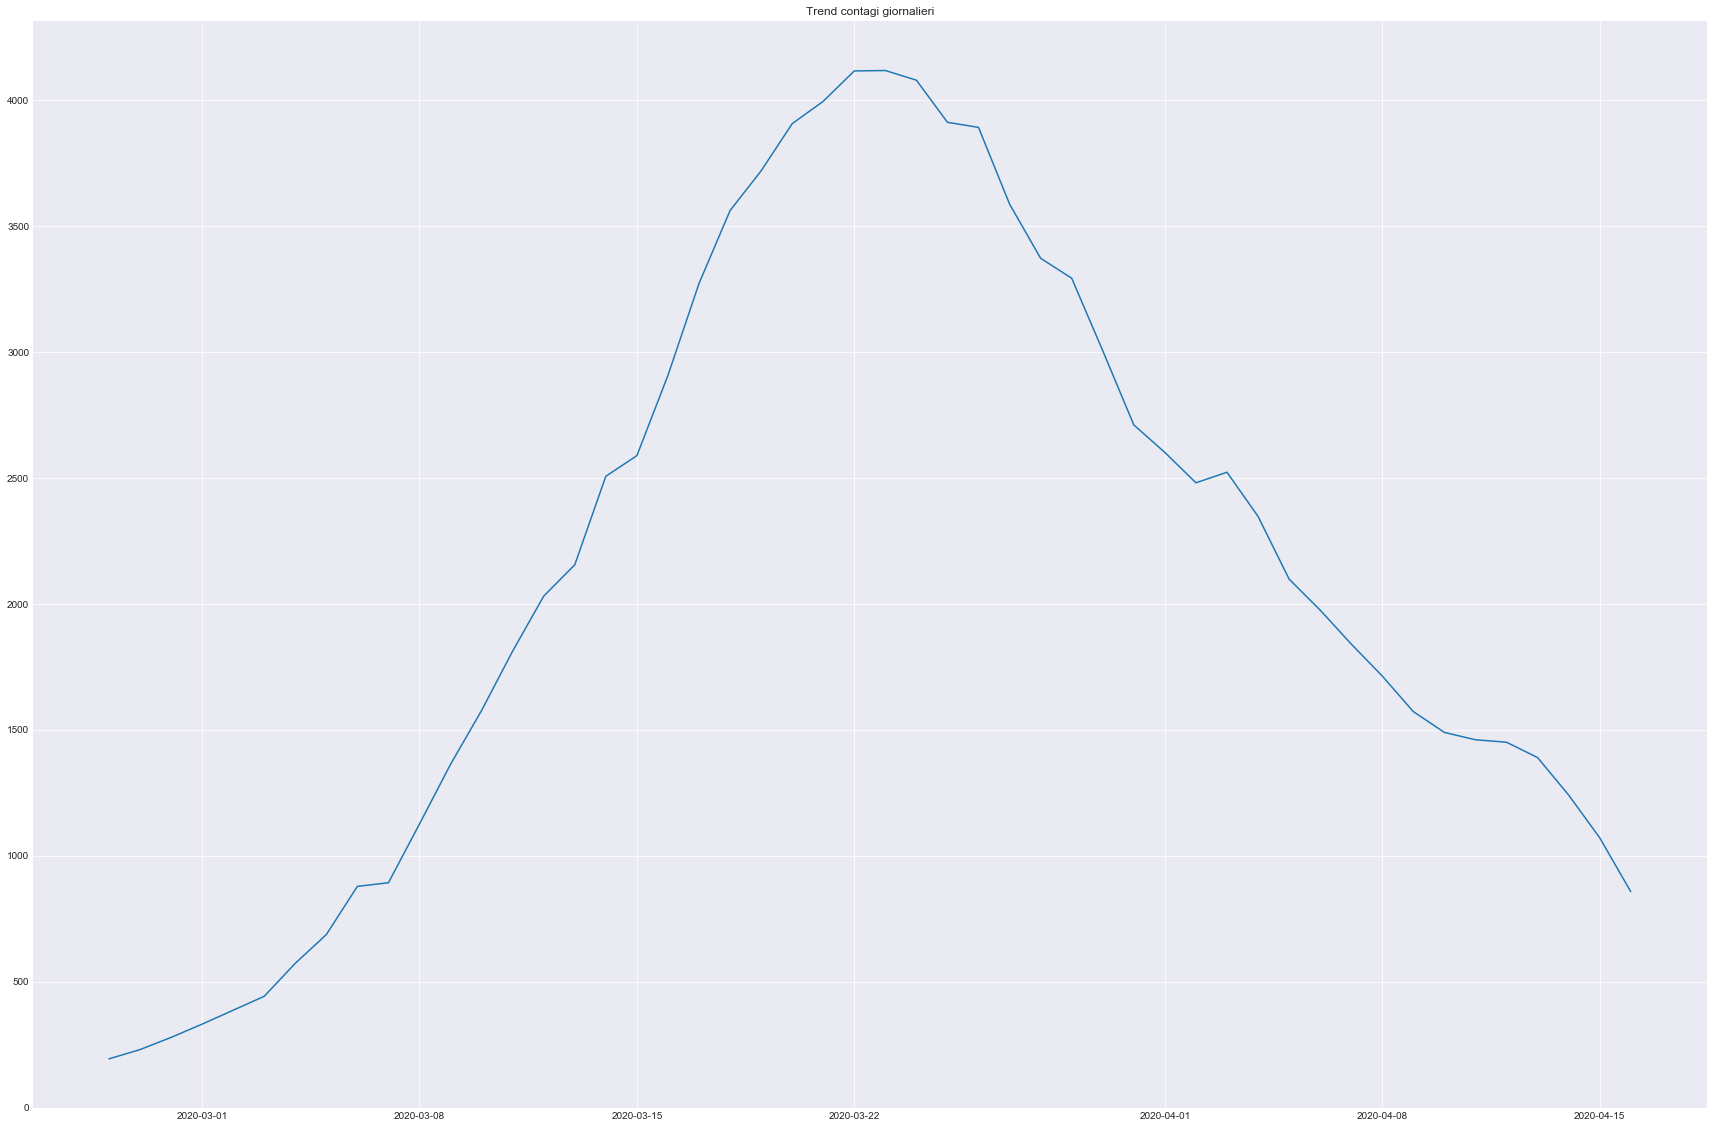

In [60]:
plt.subplots(figsize=(30,20))
plt.plot(dpc.trend)
plt.title("Trend contagi giornalieri")
plt.show()

Dalla grafico si evince che il trend dei contagi giornalieri è in diminuzione.

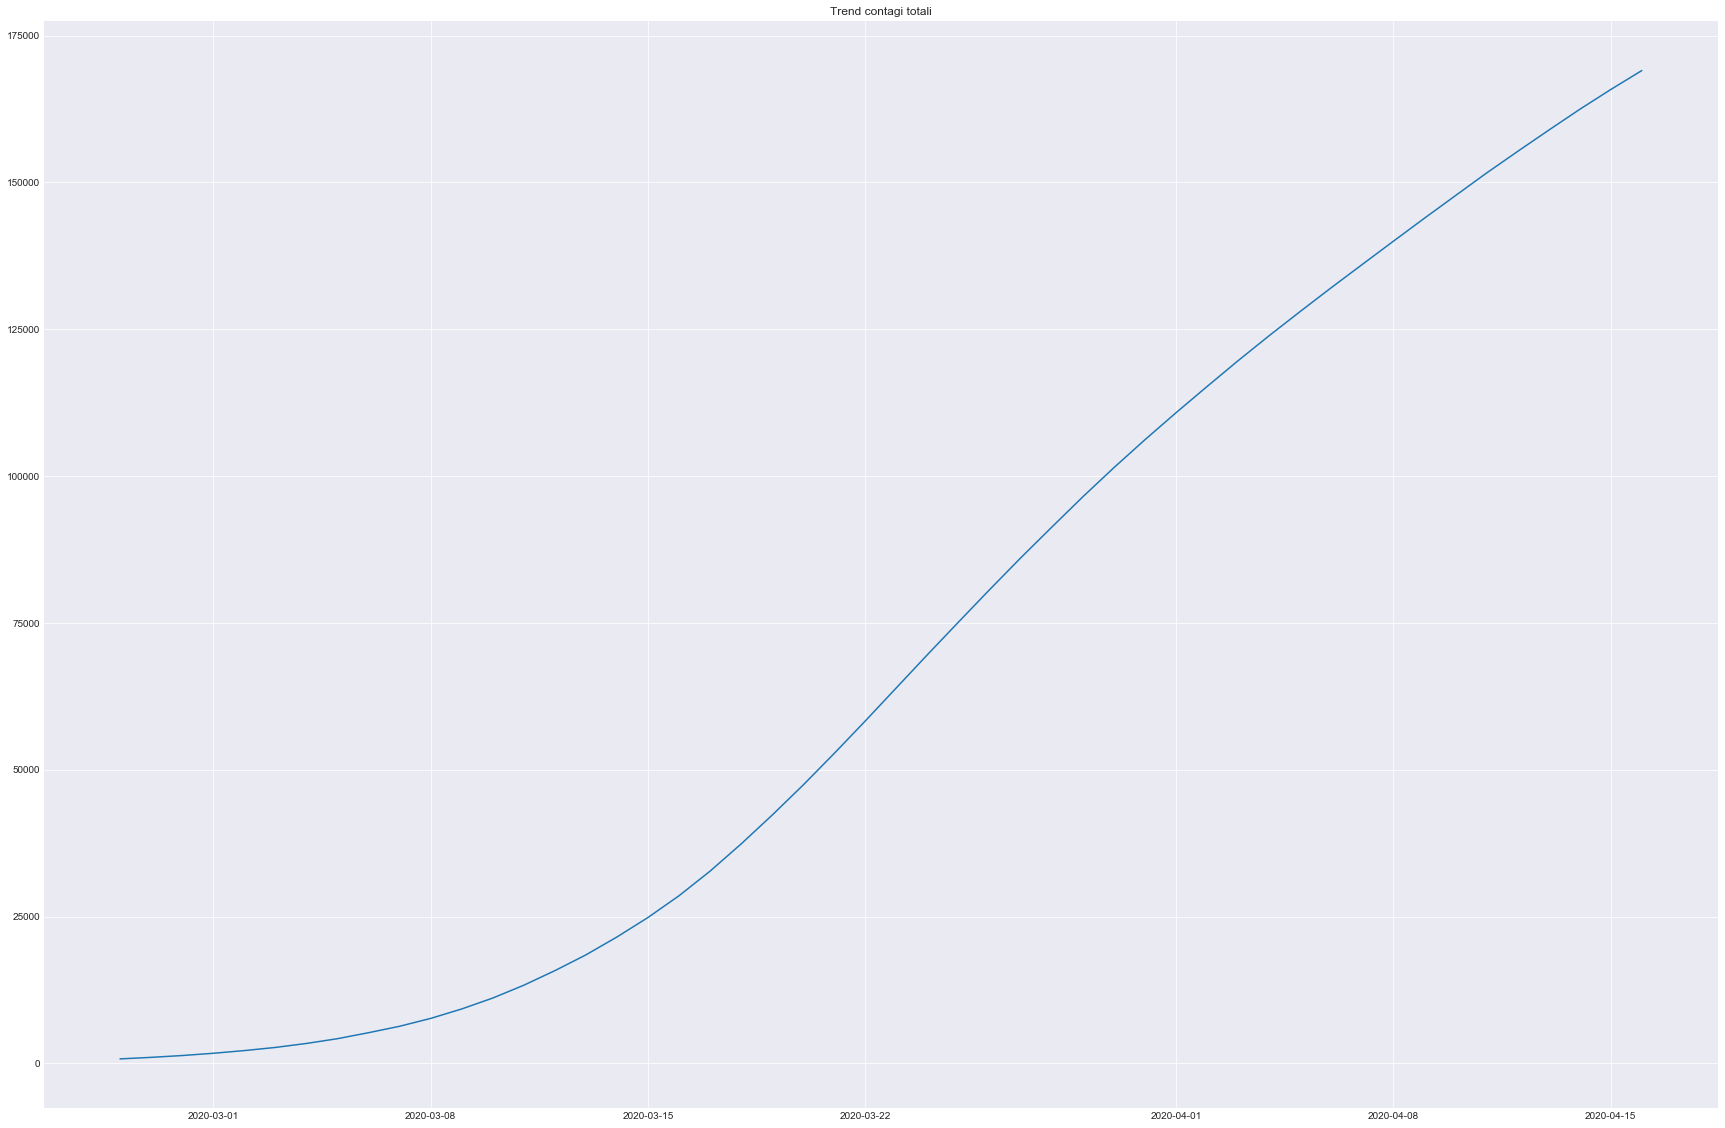

In [61]:
plt.subplots(figsize=(30,20))
plt.plot(cc.trend)
plt.title("Trend contagi totali")

plt.show()

La curva, che rappresenta il trend dei contagi totali in Italia, continua a salire in maniera più lieve rispetto le settimane precedenti.

In [62]:
#decomposizione stagionale nazionale casi cumulativi e positivi giornalieri
res_cumu=seasonal_decompose(nazz['cumulative_cases'], model='additive', extrapolate_trend='freq')
res_dail=seasonal_decompose(nazz['daily_positive_cases'], model='additive', extrapolate_trend='freq')

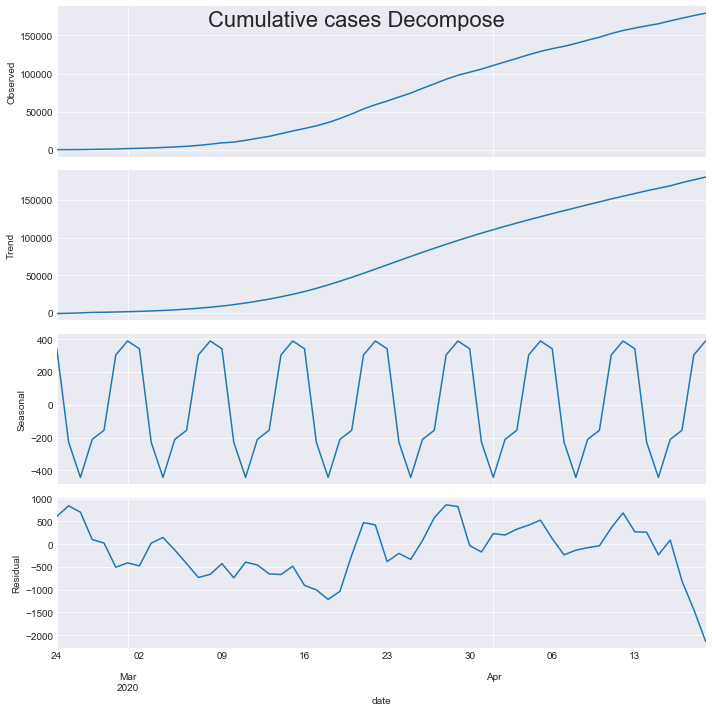

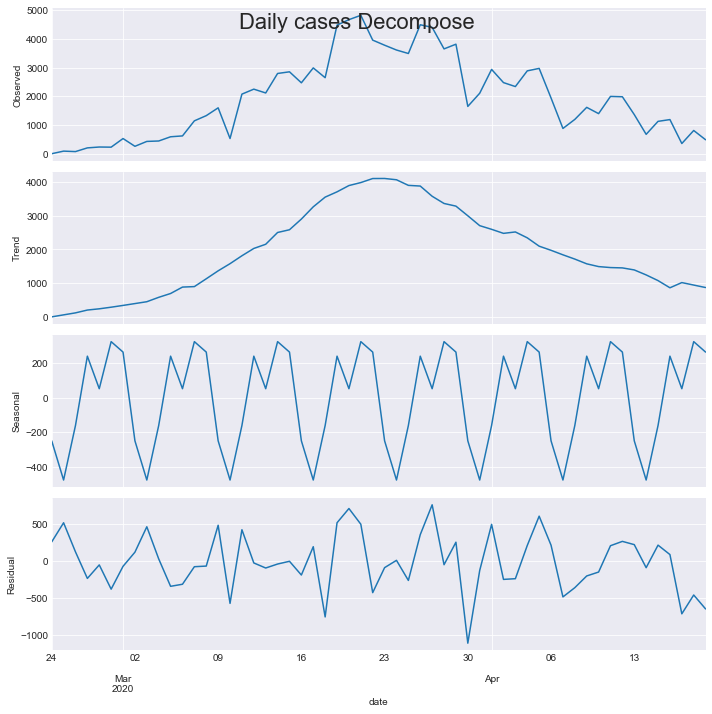

In [63]:
plt.rcParams.update({'figure.figsize': (10,10)})
res_cumu.plot().suptitle('Cumulative cases Decompose', fontsize=22)
res_dail.plot().suptitle('Daily cases Decompose', fontsize=22)

plt.show()

Decomposizione stagionale con modello additivo dei casi comulativi a livello nazionale: si denota che la componente stagionale ha dei picchi ogni circa 7 giorni, durante il weekend.

Decomposizione stagionale con modello additivo dei casi giornalieri a livello nazionale: la componente stagionale presenta picchi come la decomposizione stagionale precedente, all'incirca nello stesso periodo.